# Detectron2 training notebook
Based on the [official Detectron 2 tutorial](
https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5)

This is a notebook that can generate the model used for the image segmentation. It is intended to be used on google colab, but can easily be changed to run locally.

To run this notebook you need some extra files which are available in our google drive folder detectron2segment. The train and val folders, they contain images and their respective polygon annotations.

The output you need to save from this notebook is
- model_final.pth
- config.yml

These are used to run inference and should be placed in this folder

# Install detectron2

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
!gcc --version

# CUDA 10.2
!pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2
# opencv is pre-installed on colab
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

In [ ]:
!nvcc --version

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")   # please manually install torch 1.7 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

In [ ]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
#im = cv2.imread("./drive/MyDrive/data/train/brace.jpg")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_masks[0])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
outputs["instances"].pred_masks[0].shape
im = cv2.imread("./input.jpg")

In [ ]:
plt.imshow(outputs["instances"].pred_masks[0].cpu())

In [ ]:
plt.imshow(im)

Extract relevant element

In [ ]:
def extract(im):
    mask2 = np.asarray(outputs["instances"].pred_masks[0].cpu())*1
    mask3d = np.dstack((np.dstack((mask2, mask2)),mask2))*1
    # mask by multiplication, clip to range 0 to 255 and make integer
    result2 = (im * mask3d).clip(0, 255).astype(np.uint8)
    result2[mask3d==0] = 255
    box = np.asarray(outputs["instances"].pred_boxes[0].to('cpu').tensor[0],dtype=int)
    crop_img = result2[box[1]:box[3], box[0]:box[2]]
    return crop_img

crop_img = extract(im)
cv2_imshow(crop_img)

prøv den på et smykke


# Train on a custom dataset

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")


På smykkerne

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

def get_jewellery_dicts(directory):
    """
    NB: the image labels used to train must have more than 6 vertices.
    """
    classes = ['Jewellery']
    dataset_dicts = []
    i = 0
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])

        record["image_id"] = i
        record["file_name"] = filename
        record["height"] = 340
        record["width"] = 510

        i+=1     


        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("Jewellery_" + d, lambda d=d: get_jewellery_dicts('/content/drive/MyDrive/detectron2segment/' + d))
    MetadataCatalog.get("Jewellery_" + d).set(thing_classes=['Jewellery'])
jewellery_metadata = MetadataCatalog.get("Jewellery_train")

In [ ]:
dataset_dicts = get_jewellery_dicts("drive/MyDrive/detectron2segment/train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=jewellery_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
#train
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Jewellery_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this  dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (jewellery). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()

# cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/detectron2segment/model_final.pth"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.82   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_jewellery_dicts("drive/MyDrive/detectron2segment/val")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1], 
                   scale=0.5   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

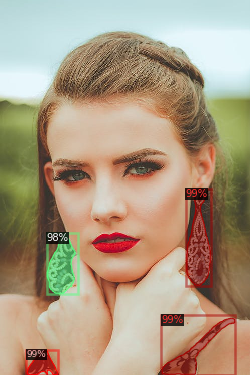

In [ ]:
im = cv2.imread("test.jpg")
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1], 
                scale=0.5  # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("Jewellery_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "Jewellery_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`